In [1]:
%matplotlib inline
import flopy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pathlib as pl
import pandas as pd
import sys
import itertools
import geopandas as gpd
import xarray as xr
from osgeo import gdal
import rasterio
import xugrid

In [2]:
sys.path.append("../common")
from liss_settings import cx, cx_provider, extent, boxx, boxy, extentmax, fig_ext, transparent

# Units

In [3]:
units = "mm"
conversion_factor = 1.0
if units == "mm":
    conversion_factor = 25.4
total_key = f"total_{units}"

# Load base MODFLOW base model

In [4]:
ws = "../modflow/pj_2018_adjust_CHDA1/base/"
sim = flopy.mf6.MFSimulation.load(sim_ws=ws, verbosity_level=0)
gwf = sim.get_model()
# Number of GHB cells 
nghb = gwf.ghb.stress_period_data.get_dataframe()[0].shape[0]
nchd = gwf.get_package("chd_coast").stress_period_data.get_dataframe()[0].shape[0]

## Model Grid

In [5]:
mg =gwf.modelgrid
mg_gdf = mg.geo_dataframe 
# Area of one cell
area = mg.delr[0]*mg.delc[0]
print(f'Cell area: {mg.delr[0]*mg.delc[0]} {mg.units}^2')
mg_gdf['row_pj'] = [x[0] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf['col_pj']=  [x[1] for x in itertools.product(range(mg.nrow), range(mg.ncol))]
mg_gdf.set_crs(epsg = 4456, inplace=True)
print(mg_gdf.crs)

Cell area: 62500.0 feet^2
EPSG:4456


## Model Cell Elevations

In [6]:
path = pl.Path(ws)/'external'
lay_arr = np.array([np.loadtxt(path / 'top.dat')] + [np.loadtxt(file) for file in sorted(path.glob('bot*.dat'))])

## Time and SP

In [7]:
tdis = sim.tdis
mf_startdate = tdis.start_date_time.array
mf_perioddata= tdis.perioddata.array
# calculate date for each stress period
mf_SPdates = [pd.to_datetime(mf_startdate)]
for perlen, nstp, tsmult in mf_perioddata:
    mf_SPdates.append(mf_SPdates[-1] + pd.Timedelta(days = perlen))
# remove the last date because it is extra
mf_SPdates = mf_SPdates[:-1]
# Compute cumulative total times at the end of each stress period
mf_totaltimes= tdis.perioddata.array['perlen'].cumsum()

mf_tdis_df = pd.DataFrame({'Date':mf_SPdates,
                           'SP': list(mf_perioddata),
                           'totim': mf_totaltimes})

## Sim Directories

In [8]:
sim_dirs_noatm = ['run_NoAtm_01.00H']
sim_dirs_noswmm = ["run_04.00H", "run_02.00H", "run_01.00H", "run_15.00M"]
sim_dirs= ["run_04.00H_withSWMM","run_02.00H_withSWMM","run_01.00H_withSWMM","run_15.00M_withSWMM" , "run_15.00M_withSWMM1min"]

# Coastal Exchange

Figure Settings

In [9]:
ws = pl.Path("figures")
ws.mkdir(exist_ok=True, parents=True)

In [10]:
# Create labels
# ===================
labels = [value.split(sep="_")[1] for value in sim_dirs]

for idx, label in enumerate(labels):
    s = f"{float(label[:5]):>2.0f}" + " " + label[-1]
    if s.endswith(" D"):
        s = s.replace(" D", " Day ")
    elif s.endswith(" H"):
        s = s.replace(" H", " Hour")
    elif s.endswith(" M"):
        s = s.replace(" M", " Min.")
    labels[idx] = s    
labels

[' 4 Hour', ' 2 Hour', ' 1 Hour', '15 Min.', '15 Min.']

In [11]:
line_styles = ["-", "--", "-.", ":", (0, (3, 10, 1, 10, 1, 10)), (0, (3, 1, 1, 1, 1, 1))]

In [12]:
colors = [value for key, value in mcolors.TABLEAU_COLORS.items()]

## GHB

### Observation Cells

In [13]:
# GHB Obs Cells
# #=====================================================
obscells_GHB = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])
obscells_GHB['cellid'] = obscells_GHB['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
obscells_GHB[['lay', 'row', 'col']] = obscells_GHB['cellid'].str.split(',', expand=True)
obscells_GHB = obscells_GHB.iloc[:-1]
obscells_GHB[['lay', 'row', 'col']] = obscells_GHB[['lay', 'row', 'col']].astype(int)
obscells_GHB[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\1858873710.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_GHB = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.ghb.obs",skiprows=5, sep=r'  ', names = ['ghb_name','head','cellid'])


### Observation Output

In [14]:
obsdict_GHB = {value: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{value}")} for value in sim_dirs + sim_dirs_noswmm}

for key, value in obsdict_GHB.items():
    obs_path = value["ws"] / "outputs" /"GHB_obs.csv"
    print(obs_path)
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    # Calculate the length of each timestep
    df["delt"] = df["totim"].diff()
    # Replace the first rows time step length because it will be nan
    df.loc[df["delt"].isnull(), "delt"] = df["delt"].iloc[1]
    # remove total time column
    df.drop("totim", axis=1, inplace=True)
    df["TOTAL_ft^3"] = 0.0
    df['TOTAL_ft'] = 0.0
    df["TOTAL_mm"] = 0.0

    # Convert values from ft^3 to mm , and create total column that sums all GHB cells
    for col_name in df.columns: 
        df['TOTAL_ft^3'] +=  df[col_name] 
        # speficic discharge
        df['TOTAL_ft'] = df['TOTAL_ft^3'] /(nghb*area)
        # ft^3 to mm
        df["TOTAL_mm"] += (conversion_factor * 12.0 * df[col_name])  /(nghb*area)

    # cumulative sum
    df["CUM_TOTAL_ft"] = df['TOTAL_ft'].cumsum() * df['delt']
    df["CUM_TOTAL_mm"] = df["TOTAL_mm"].cumsum() * df['delt']

    df["ZERO"] = 0.
    df.drop("delt", axis=1, inplace=True)
    # number of timesteps
    obsdict_GHB[key]["ntimes"] = df.shape[0]
    # store DF
    obsdict_GHB[key]["df"] = df.copy()
    # Final cumulative total 
    obsdict_GHB[key][total_key] = df["CUM_TOTAL_ft"].iloc[-1]

cum_labels_GHB = []
for idx, value in enumerate(sim_dirs):
    total_flux = obsdict_GHB[value][total_key]
    cum_labels_GHB.append(f"{labels[idx]} ({total_flux:5.2f} ft)")
cum_labels_GHB

..\modflow\pj_2018_adjust_CHDA1\run_04.00H_withSWMM\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_02.00H_withSWMM\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_01.00H_withSWMM\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM1min\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_04.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_02.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_01.00H\outputs\GHB_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M\outputs\GHB_obs.csv


[' 4 Hour (-5.82 ft)',
 ' 2 Hour (-3.35 ft)',
 ' 1 Hour (-2.11 ft)',
 '15 Min. (-1.18 ft)',
 '15 Min. (-1.20 ft)']

## CHD

### Observation Cells

In [15]:
# CHD Obs Cells
# #=====================================================
obscells_CHD = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])
obscells_CHD['cellid'] = obscells_CHD['cellid'].str.replace(r'\s+', ',', regex=True)
obscells_CHD[['lay', 'row', 'col']] = obscells_CHD['cellid'].str.split(',', expand=True)
obscells_CHD = obscells_CHD.iloc[:-1]
obscells_CHD[['lay', 'row', 'col']] = obscells_CHD[['lay', 'row', 'col']].astype(int)
obscells_CHD[['lay', 'row', 'col']]-=1

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\1871002641.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_CHD = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf_0.chd.obs",skiprows=5, sep=r'  ', names = ['chd_name','head','cellid'])


In [16]:
# Split up obs cells based on how you want to analyze them
#-===================================================
# all CHDs on the surface
obscells_CHDsurface = obscells_CHD[obscells_CHD['lay'] == 0]
# all perimeter CHDs on the coast
obscells_CHDperimeter  = obscells_CHD[obscells_CHD['chd_name'].str.contains('perimeter')]
# perimeter CHDs on the coast that are not in layer 1
obscells_CHDdepth= obscells_CHD[obscells_CHD['lay'] != 0]

# Determine the observation names in order to drop column names later
obsname_CHDdepth = set(obscells_CHD.loc[obscells_CHDdepth.index, 'chd_name'].str.upper().str.replace("'", ""))
obsname_CHDsurface = set(obscells_CHD.loc[obscells_CHDsurface.index, 'chd_name'].str.upper().str.replace("'", ""))
obsname_perimeter = set(obscells_CHD.loc[obscells_CHDperimeter.index, 'chd_name'].str.upper().str.replace("'", ""))

### Observation Output

In [17]:
# Save observation results for all simulations
# ======================================
obsdict_CHD = {}
for sim in sim_dirs_noatm+sim_dirs + sim_dirs_noswmm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\chd_coastal_obs.csv'
    print(f'loading:{obs_path}')
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    # Initialize total columns
    for col in ["TOTAL_ft^3", "TOTAL_ft", "TOTAL_mm", "CUM_TOTAL_ft", "CUM_TOTAL_mm", "ZERO"]:
        df[col] = 0.0
    # Calculate timestep length safely
    df["delt"] = df["totim"].diff().fillna(method="bfill")
    df.drop("totim", axis=1, inplace=True)
    obsdict_CHD[sim] = df

loading:..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_04.00H_withSWMM\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_02.00H_withSWMM\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_01.00H_withSWMM\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM1min\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_04.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_02.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_01.00H\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


loading:..\modflow\pj_2018_adjust_CHDA1\run_15.00M\outputs\chd_coastal_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\2627340914.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["delt"] = df["totim"].diff().fillna(method="bfill")


In [18]:
# Define total_key
total_key = "TOTAL_CUM_ft"

# ---------------- Prepare dictionaries ----------------
obsdict_CHDsurface = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in (sim_dirs+sim_dirs_noswmm+sim_dirs_noatm)}
obsdict_CHDsurface_noperim = {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in (sim_dirs+sim_dirs_noswmm+sim_dirs_noatm)}
obsdict_CHDdepth= {v: {"ws": pl.Path(f"../modflow/pj_2018_adjust_CHDA1/{v}")} for v in (sim_dirs+sim_dirs_noswmm+sim_dirs_noatm)}

# Columns to exclude from totals
total_ignore_cols = ["delt", "TOTAL_ft^3", "TOTAL_ft", "TOTAL_mm", "CUM_TOTAL_ft", "CUM_TOTAL_mm", "ZERO"]

# ---------------- Process each simulation ----------------
for sim in sim_dirs+sim_dirs_noswmm+sim_dirs_noatm:
    print(sim)
    df = obsdict_CHD[sim]
    # ---------- Surface Coastal Observations ----------
    # drop the cells in layers >0
    df = df.drop(columns=obsname_CHDdepth, errors='ignore')
    obs_cols = [c for c in df.columns if c not in total_ignore_cols]

    # Vectorized totals
    df['TOTAL_ft^3'] = df[obs_cols].sum(axis=1)
    df['TOTAL_mm'] = (df[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    df['TOTAL_ft'] = df['TOTAL_ft^3'] / (nchd * area)
    df['CUM_TOTAL_ft'] = (df['TOTAL_ft'] * df['delt']).cumsum()
    df['CUM_TOTAL_mm'] = (df['TOTAL_mm'] * df['delt']).cumsum()

    # Save
    obsdict_CHDsurface[sim]["df"] = df
    obsdict_CHDsurface[sim]["ntimes"] = df.shape[0]
    obsdict_CHDsurface[sim][total_key] = df['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Surface Coastal Observations - No Perimeter ----------
    # Drops all perimeter cells 
    drop_cols = obsname_CHDdepth.union(obsname_perimeter)
    df = df.drop(columns=drop_cols, errors='ignore')
    obs_cols = [c for c in df.columns if c not in total_ignore_cols]

    df['TOTAL_ft^3'] = df[obs_cols].sum(axis=1)
    df['TOTAL_mm'] = (df[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    df['TOTAL_ft'] = df['TOTAL_ft^3'] / (nchd * area)
    df['CUM_TOTAL_ft'] = (df['TOTAL_ft'] * df['delt']).cumsum()
    df['CUM_TOTAL_mm'] = (df['TOTAL_mm'] * df['delt']).cumsum()

    obsdict_CHDsurface_noperim[sim]["df"] = df
    obsdict_CHDsurface_noperim[sim]["ntimes"] = df.shape[0]
    obsdict_CHDsurface_noperim[sim][total_key] = df['CUM_TOTAL_ft'].iloc[-1]

    # ---------- Depth Coastal Observations ----------
    df =obsdict_CHD[sim]
    # drop all surface cells
    df = df.drop(columns=obsname_CHDsurface, errors='ignore')
    obs_cols = [c for c in df.columns if c not in total_ignore_cols]

    df['TOTAL_ft^3'] = df[obs_cols].sum(axis=1)
    df['TOTAL_mm'] = (df[obs_cols].sum(axis=1) * conversion_factor * 12.0) / (nchd * area)
    df['TOTAL_ft'] = df['TOTAL_ft^3'] / (nchd * area)
    df['CUM_TOTAL_ft'] = (df['TOTAL_ft'] * df['delt']).cumsum()
    df['CUM_TOTAL_mm'] = (df['TOTAL_mm'] * df['delt']).cumsum()

    obsdict_CHDdepth[sim]["df"] = df
    obsdict_CHDdepth[sim]["ntimes"] = df.shape[0]
    obsdict_CHDdepth[sim][total_key] = df['CUM_TOTAL_ft'].iloc[-1]

    print(f"Saved DataFrames for {sim} successfully.\n")


run_04.00H_withSWMM
Saved DataFrames for run_04.00H_withSWMM successfully.

run_02.00H_withSWMM
Saved DataFrames for run_02.00H_withSWMM successfully.

run_01.00H_withSWMM
Saved DataFrames for run_01.00H_withSWMM successfully.

run_15.00M_withSWMM
Saved DataFrames for run_15.00M_withSWMM successfully.

run_15.00M_withSWMM1min
Saved DataFrames for run_15.00M_withSWMM1min successfully.

run_04.00H
Saved DataFrames for run_04.00H successfully.

run_02.00H
Saved DataFrames for run_02.00H successfully.

run_01.00H
Saved DataFrames for run_01.00H successfully.

run_15.00M
Saved DataFrames for run_15.00M successfully.

run_NoAtm_01.00H
Saved DataFrames for run_NoAtm_01.00H successfully.



## Figure

### D-flow  + MF coupling (with and without D-flow atmospheric inputrs)

In [19]:
# start_date = pd.Timestamp('2018-09-28 00:00:00')

# with flopy.plot.styles.USGSMap():
#     fig, ax = plt.subplots(layout="constrained", figsize=(8,4))

#     df_chd = obsdict_CHDsurface_noperim['run_NoAtm_01.00H']["df"]
#     df_chd.index = pd.to_datetime(df_chd.index)
#     df_chd['TOTAL_ft^3'].plot(ax=ax, lw=0.75, ls="-", color='black', label="Dflow-FM: no atmosphere")

#     df_chd = obsdict_CHDsurface_noperim['run_01.00H']["df"]
#     df_chd.index = pd.to_datetime(df_chd.index)
#     df_chd['TOTAL_ft^3'].plot(ax=ax, lw=0.75, ls="--", color='magenta', label="Dflow-FM: with atmosphere")

#     ax.set_ylabel("Coastal\nexchange, ft^3")
#     ax.set_xlabel("")
#     ax.set_xlim(start_date, df_chd.index[-1])
#     flopy.plot.styles.heading(ax, heading= '1 hour')

#     fig.suptitle('DFLOW-FM with and without atm \n Coastal Exchange \n 1 Hour Coupling')
#     flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)
# fig.savefig('figures/DflowVersions_CHDexchange')

### Coastal Exchange time series

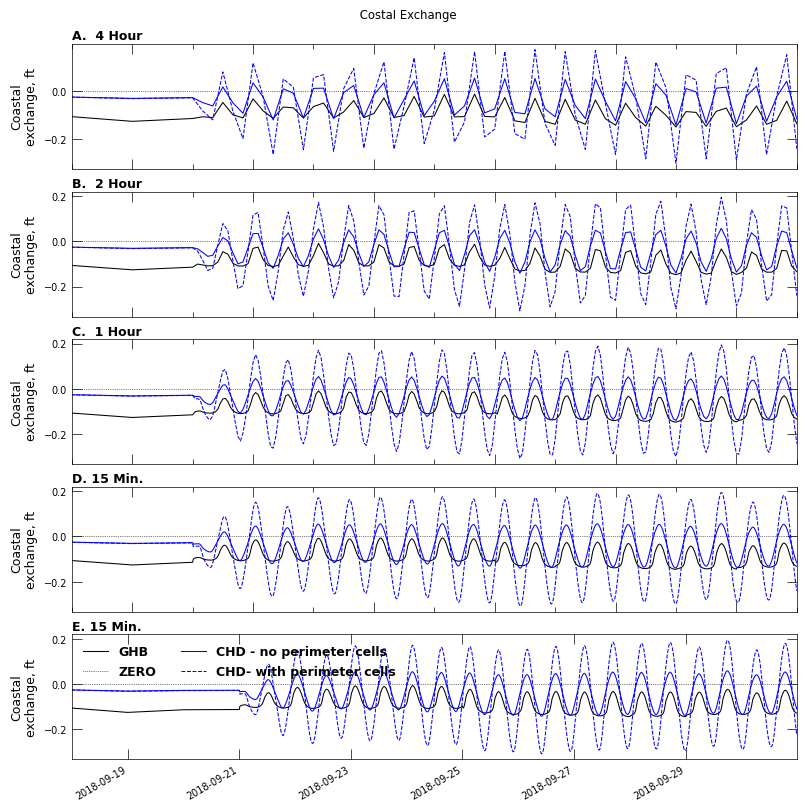

In [20]:
#=================================================================
start_date = pd.Timestamp('2018-09-18 00:00:00')

with flopy.plot.styles.USGSMap():
    fig, axs = plt.subplots(
        ncols=1,
        nrows=len(labels),
        layout="constrained",
        figsize=(8,8),
        )
    for idx in range(len(sim_dirs)):
        ax = axs[idx]
       # ax.set_ylim(-1 * conversion_factor, 1 * conversion_factor)
        df_ghb = obsdict_GHB[sim_dirs[idx]]["df"]
        df_ghb["TOTAL_ft"].plot(ax=ax, lw=0.75, ls="-", color='black',sharex=True, label= "GHB")
        df_ghb["ZERO"].plot(ax=ax, lw=0.5, ls=":", color="black", sharex=True)
        
        df_chd = obsdict_CHDsurface_noperim[sim_dirs[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='blue', sharex=True, label ="CHD - no perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        df_chd = obsdict_CHDsurface[sim_dirs[idx]]["df"]
        df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="--", color='blue', sharex=True, label ="CHD- with perimeter cells")
        #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

        ax.set_ylabel(f"Coastal\nexchange, ft")
        ax.set_xlabel("")
        ax.set_xlim(start_date, df_ghb.index[-1])
        flopy.plot.styles.heading(ax, idx=idx, heading=labels[idx])

    ax = axs[-1]

    #ax.set_ylim(0, 15 * conversion_factor)
    
    # for idx, value in enumerate(sim_dirs_noatm):
    #     obsdict_GHB[value]["df"]["CUM_TOTAL"].plot(ax=ax, lw=0.75, ls=line_styles[idx], color=colors[idx], label=cum_labels[idx])
    # ax.set_ylabel(f"Cumulative coastal\nexchange, {units}")
    # ax.set_xlim(start_date, df_ghb.index[-1])
    # ax.set_xlabel("")
    # flopy.plot.styles.heading(ax, idx=len(labels), heading="Cumulative")
    fig.suptitle(' Costal Exchange')
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)
# fi

In [21]:
obsdict_CHDsurface_noperim.keys()

dict_keys(['run_04.00H_withSWMM', 'run_02.00H_withSWMM', 'run_01.00H_withSWMM', 'run_15.00M_withSWMM', 'run_15.00M_withSWMM1min', 'run_04.00H', 'run_02.00H', 'run_01.00H', 'run_15.00M', 'run_NoAtm_01.00H'])

In [22]:
sim_dirs_noswmm

['run_04.00H', 'run_02.00H', 'run_01.00H', 'run_15.00M']

In [23]:
sim_dirs

['run_04.00H_withSWMM',
 'run_02.00H_withSWMM',
 'run_01.00H_withSWMM',
 'run_15.00M_withSWMM',
 'run_15.00M_withSWMM1min']

In [24]:
# #=================================================================
# start_date = pd.Timestamp('2018-09-28 00:00:00')

# with flopy.plot.styles.USGSMap():
#     fig, axs = plt.subplots(
#         ncols=1,
#         nrows=len(sim_dirs),
#         layout="constrained",
#         figsize=(8,8),
#         )
#     for idx in range(len(sim_dirs)-1):
#         ax = axs[idx]

#         # df_ghb = obsdict_GHB[sim_dirs[idx]]["df"]
#         # df_ghb["TOTAL_ft"].plot(ax=ax, lw=1.75, ls=":", color='black',sharex=True, label= "GHB")
#         # df_ghb["ZERO"].plot(ax=ax, lw=0.5, ls=":", color="black", sharex=True)
        
#         df_chd = obsdict_CHDsurface_noperim[sim_dirs[idx]]["df"]
#         df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='black', sharex=True, label ="CHD - no swmm")
#         df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

#         df_chd = obsdict_CHDsurface_noperim[sim_dirs_noswmm[idx]]["df"]
#         df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='green', sharex=True, label ="CHD - with swmm")
#         df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

#         # df_chd = obsdict_CHDsurface[sim_dirs[idx]]["df"]
#         # df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="--", color='cyan', sharex=True, label ="CHD- with perimeter cells")
#         # #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

#         ax.set_ylabel(f"Coastal\nexchange, ft")
#         ax.set_xlabel("")
#         ax.set_xlim(start_date, df_ghb.index[-1])
#         flopy.plot.styles.heading(ax, idx=idx, heading=sim_dirs[idx])


#     fig.suptitle(' Costal Exchange')
#     leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)


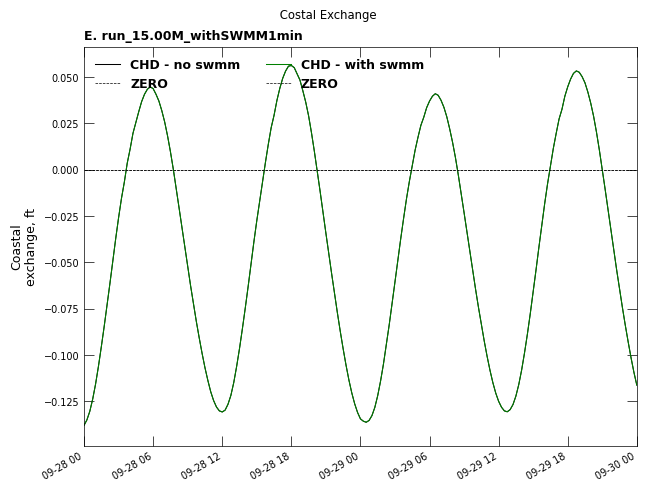

In [25]:
#=================================================================
start_date = pd.Timestamp('2018-09-28 00:00:00')
end_date = pd.Timestamp('2018-09-30 00:00:00')
key = 'run_15.00M_withSWMM'
key1 = 'run_15.00M'
with flopy.plot.styles.USGSMap():
    fig, ax = plt.subplots(
        layout="constrained",
        )

    df_chd = obsdict_CHDsurface_noperim[key]["df"]
    df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='black', sharex=True, label ="CHD - no swmm")
    df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

    df_chd = obsdict_CHDsurface_noperim[key1]["df"]
    df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="-", color='green', sharex=True, label ="CHD - with swmm")
    df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

    # df_chd = obsdict_CHDsurface[sim_dirs[idx]]["df"]
    # df_chd['TOTAL_ft'].plot(ax=ax, lw=0.75, ls="--", color='cyan', sharex=True, label ="CHD- with perimeter cells")
    # #df_chd["ZERO"].plot(ax=ax, lw=0.5, ls="--", color="black", sharex=True)

    ax.set_ylabel(f"Coastal\nexchange, ft")
    ax.set_xlabel("")
    ax.set_xlim(start_date, end_date)
    flopy.plot.styles.heading(ax, idx=idx, heading=sim_dirs[idx])


    fig.suptitle(' Costal Exchange')
    leg = flopy.plot.styles.graph_legend(ax=ax, loc="upper left", title="none", ncol=2)


### Coastal Exchange Map

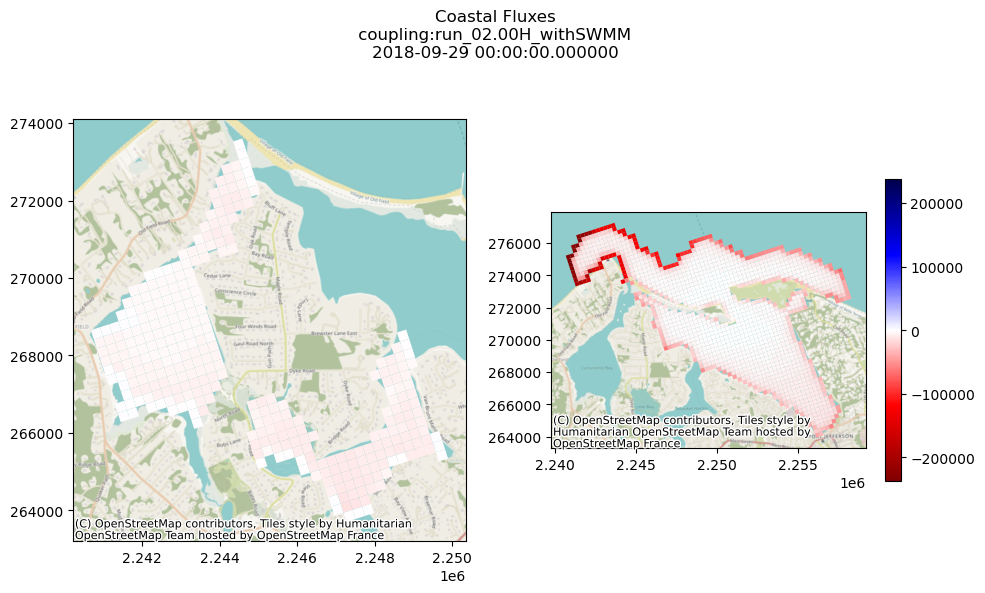

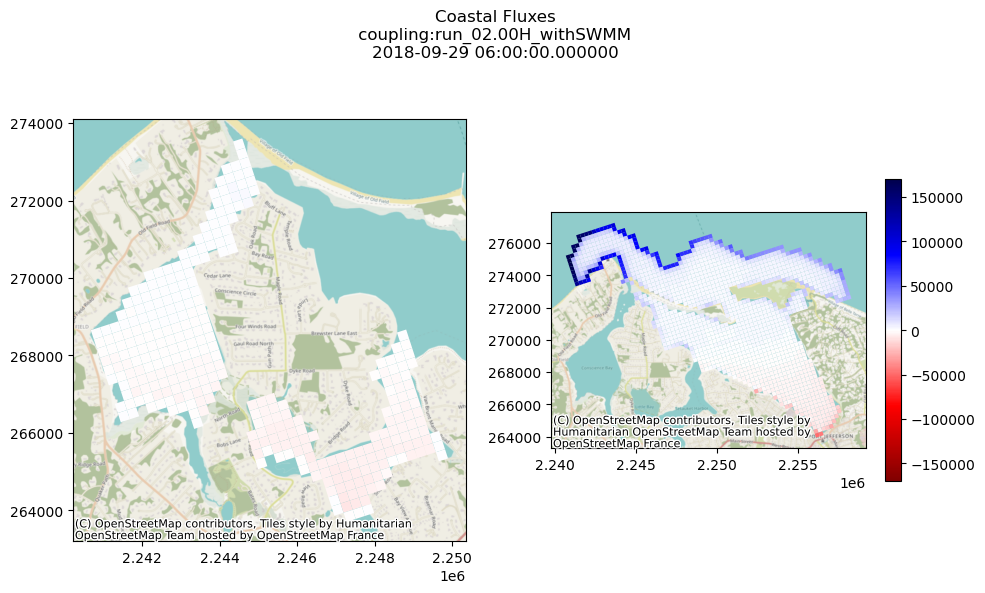

In [26]:
sim = sim_dirs[1]
datetimes  = "2018-09-29 00:00:00.000000" ,  "2018-09-29 06:00:00.000000"

for datetime in datetimes:
    # GHB 
    # ==========
    #Populate map with GHB values
    mg_ghb = mg_gdf.copy()
    mg_ghb['ghb_flux'] = float(0)
    #Populate map with GHB values
    for r,c in zip(obscells_GHB['row'], obscells_GHB['col']):
        # identify the ghb cell name from the row,col
        name = obscells_GHB.loc[((obscells_GHB['row'] == r) & (obscells_GHB['col'] == c)), 'ghb_name'].iloc[0]
        # use the ghb name to correctly index the observation results
        mg_ghb.loc[((mg_ghb['row_pj'] == r) & (mg_ghb['col_pj'] == c)),'ghb_flux'] = obsdict_GHB[sim]['df'][name.upper()].loc[datetime]

    #CHD
    #===========
    #Populate map with CHD values
    mg_chd = mg_gdf.copy()
    mg_chd['chd_flux'] =float(0)
    for name,r,c in zip(obscells_CHDsurface['chd_name'],obscells_CHDsurface['row'], obscells_CHDsurface['col']):
        name = name.upper().replace("'","")
        mg_chd.loc[((mg_chd['row_pj'] == r) & (mg_chd['col_pj'] == c)),'chd_flux'] = obsdict_CHDsurface[sim]['df'][name].loc[datetime]

    #Figure
    #---------
    fig, ax = plt.subplots(1,2, figsize = (10,6))
    vmin = mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].min()
    vmax =  mg_chd[mg_chd['chd_flux']!=0]['chd_flux'].max()
    absmax = max(abs(vmin),abs(vmax))
    #vmax = 0
    mg_ghb[mg_ghb['ghb_flux']!=0].plot(column = 'ghb_flux', cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[0], legend_kwds={'shrink': 0.6}) # shrink colorbar to 60% of axis height
    cx.add_basemap(ax=ax[0], crs=mg_ghb.crs)
    mg_chd[mg_chd['chd_flux']!=0].plot(column = 'chd_flux', legend=True, cmap='seismic_r', vmin=-absmax, vmax=absmax, ax=ax[1] ,legend_kwds={'shrink': 0.6})  # shrink colorbar to 60% of axis height
    cx.add_basemap(ax=ax[1], crs=mg_ghb.crs)
    fig.suptitle(f'Coastal Fluxes\n coupling:{sim} \n{datetime}')
    fig.tight_layout()   
    plt.show()

# SWMM obs cells

C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\3049440414.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_wells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\run_01.00H_withSWMM\gwf_0.wel.obs",skiprows=5, sep=r'  ', names = ['obs_name','obstyp','cellid'])


Text(0.5, 1.0, 'SWMM network as wells')

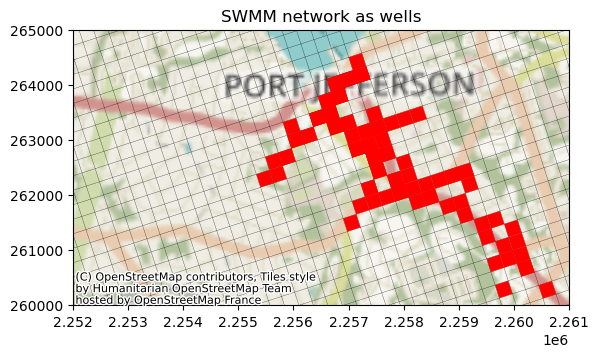

In [27]:
obscells_wells = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\run_01.00H_withSWMM\gwf_0.wel.obs",skiprows=5, sep=r'  ', names = ['obs_name','obstyp','cellid'])

obscells_wells['cellid'] = obscells_wells['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
obscells_wells[['lay', 'row', 'col']] = obscells_wells['cellid'].str.split(',', expand=True)
obscells_wells = obscells_wells.iloc[:-1]
obscells_wells[['lay', 'row', 'col']] = obscells_wells[['lay', 'row', 'col']].astype(int)
obscells_wells[['lay', 'row', 'col']]-=1
obscells_wells

fig,ax = plt.subplots()
mg_gdf.plot(ax=ax,facecolor='none', edgecolor='black',linewidth=0.1)
for r,c in zip(obscells_wells['row'], obscells_wells['col']):
    mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax, color = 'r')
cx.add_basemap(ax=ax,crs = mg_gdf.crs)
ax.set_ylim(260000,265000)
ax.set_xlim(2252000,2261000)
ax.set_title('SWMM network as wells')

In [28]:
date = pd.Timestamp('2018-09-25 00:00:00')
# Value to search for
search_value = 3.000000e+30
# Save Well Observation Results 
# ======================================
obsdict_WEL = {}
obsdict_WELstats = {}
for sim in sim_dirs:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\swmm_well_obs.csv'
    print(f'loading well observations for {sim}')
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    df.drop('totim',axis=1, inplace=True)
    cols_with_value = df.columns[(df == 3.000000e+30).any()]
    for col in cols_with_value:
        print(f'{col} has values : {search_value}')
        # df.drop(col, axis=1, inplace=True)

    # compute stats
    # Note: the sum will be higher with a greater coupling frequency right?
    stats_df = pd.DataFrame({
    'mean': df.mean(),
    'min': df.min(),
    'max': df.max(),
    'sum':df.sum()}).T # transpose so stats are ro
    print(f'{sim}')
    obsdict_WELstats[sim] = stats_df
    
    obs_cols = [c for c in df.columns if c not in cols_with_value]
    df['TOTAL'] = df[obs_cols].sum(axis=1)
    obsdict_WEL[sim] = df
    
    # Determine what dates have the largest and smallest well exchange
    max_idx = df["TOTAL"].where(df.index >= date).idxmax()
    min_idx = df["TOTAL"].where(df.index >= date).idxmin()
    print("Largest TOTAL in range:", max_idx, df.loc[max_idx, "TOTAL"])
    print("Smallest TOTAL in range:", min_idx, df.loc[min_idx, "TOTAL"])

    # display tables
    display(df[date:].head())
    display(stats_df)



loading well observations for run_04.00H_withSWMM
J61 has values : 3e+30
run_04.00H_withSWMM
Largest TOTAL in range: 2018-09-25 00:00:00 3.9796751592774617
Smallest TOTAL in range: 2018-09-27 19:59:59.999997 3.8456905208967704


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J71,J72,J73,J74,J75,J76,J78,J79,J77,TOTAL
2018-09-25 00:00:00.000000,0.100258,0.188540,0.188540,0.081132,0.089846,0.081693,0.081463,0.100372,0.093089,0.074699,...,0.052469,0.062223,0.062223,0.031057,0.031057,0.015442,0.021489,0.030018,0.021489,3.979675
2018-09-25 04:00:00.000003,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492,3.979116
2018-09-25 07:59:59.999997,0.099823,0.187617,0.187617,0.080682,0.089389,0.081251,0.081010,0.099905,0.092640,0.074224,...,0.052018,0.062175,0.062175,0.031012,0.031012,0.015352,0.021442,0.029841,0.021442,3.879805
2018-09-25 12:00:00.000000,0.099802,0.187567,0.187567,0.080656,0.089364,0.081226,0.080985,0.099880,0.092615,0.074199,...,0.051996,0.062125,0.062125,0.030965,0.030965,0.015329,0.021393,0.028047,0.021393,3.896602
2018-09-25 16:00:00.000003,0.099781,0.187517,0.187517,0.080631,0.089339,0.081202,0.080959,0.099855,0.092589,0.074173,...,0.051974,0.062076,0.062076,0.030919,0.030919,0.015305,0.021344,0.027860,0.021344,3.894172


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J70,J71,J72,J73,J74,J75,J76,J78,J79,J77
mean,0.018163,0.034149,0.034149,0.014690,0.016271,0.014792,0.014750,0.018182,0.016861,0.013521,...,0.009478,0.009488,0.011256,0.011256,0.005598,0.005598,0.002779,0.003858,0.005275,0.003858
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052408,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492
sum,5.902936,11.098546,11.098546,4.774217,5.288157,4.807358,4.793699,5.909289,5.479682,4.394283,...,3.080214,3.083546,3.658064,3.658064,1.819279,1.819279,0.903296,1.253994,1.714517,1.253994


loading well observations for run_02.00H_withSWMM
J61 has values : 3e+30
run_02.00H_withSWMM
Largest TOTAL in range: 2018-09-25 00:00:00 3.9856422211499156
Smallest TOTAL in range: 2018-09-27 19:59:59.999997 3.836144594479003


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J71,J72,J73,J74,J75,J76,J78,J79,J77,TOTAL
2018-09-25 00:00:00.000000,0.100259,0.188541,0.188541,0.081133,0.089846,0.081694,0.081463,0.100373,0.093090,0.074699,...,0.052470,0.062224,0.062224,0.031058,0.031058,0.015443,0.021490,0.030024,0.021490,3.985642
2018-09-25 01:59:59.999997,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030031,0.021492,3.979567
2018-09-25 04:00:00.000003,0.099834,0.187642,0.187642,0.080695,0.089401,0.081264,0.081022,0.099918,0.092653,0.074237,...,0.052029,0.062200,0.062200,0.031036,0.031036,0.015365,0.021467,0.029938,0.021467,3.896288
2018-09-25 06:00:00.000000,0.099823,0.187617,0.187617,0.080682,0.089389,0.081251,0.081010,0.099905,0.092640,0.074224,...,0.052018,0.062175,0.062175,0.031012,0.031012,0.015353,0.021442,0.029844,0.021442,3.879442
2018-09-25 07:59:59.999997,0.099813,0.187592,0.187592,0.080669,0.089376,0.081239,0.080997,0.099892,0.092627,0.074211,...,0.052007,0.062149,0.062149,0.030988,0.030988,0.015340,0.021417,0.028124,0.021417,3.877347


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J70,J71,J72,J73,J74,J75,J76,J78,J79,J77
mean,0.030925,0.058144,0.058144,0.025011,0.027704,0.025185,0.025113,0.030958,0.028707,0.023021,...,0.016137,0.016154,0.019164,0.019164,0.009531,0.009531,0.004732,0.006569,0.008982,0.006569
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052408,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030031,0.021492
sum,11.905966,22.385277,22.385277,9.629387,10.665982,9.696230,9.668682,11.918775,11.052274,8.863085,...,6.212647,6.219379,7.378009,7.378009,3.669264,3.669264,1.821844,2.529099,3.458218,2.529099


loading well observations for run_01.00H_withSWMM
J61 has values : 3e+30
run_01.00H_withSWMM
Largest TOTAL in range: 2018-09-25 00:00:00 3.98446889914316
Smallest TOTAL in range: 2018-09-27 19:00:00.000003 3.8357799382653797


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J71,J72,J73,J74,J75,J76,J78,J79,J77,TOTAL
2018-09-25 00:00:00.000000,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081463,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031059,0.031059,0.015443,0.021491,0.030027,0.021491,3.984469
2018-09-25 01:00:00.000003,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492,3.979809
2018-09-25 01:59:59.999997,0.099839,0.187655,0.187655,0.080701,0.089407,0.081270,0.081029,0.099924,0.092659,0.074243,...,0.052034,0.062213,0.062213,0.031048,0.031048,0.015371,0.021480,0.029986,0.021480,3.910085
2018-09-25 03:00:00.000000,0.099834,0.187642,0.187642,0.080695,0.089401,0.081264,0.081022,0.099918,0.092653,0.074237,...,0.052029,0.062200,0.062200,0.031036,0.031036,0.015365,0.021467,0.029939,0.021467,3.895584
2018-09-25 04:00:00.000003,0.099829,0.187629,0.187629,0.080688,0.089395,0.081257,0.081016,0.099911,0.092646,0.074230,...,0.052023,0.062187,0.062187,0.031024,0.031024,0.015359,0.021455,0.029892,0.021455,3.884793


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J70,J71,J72,J73,J74,J75,J76,J78,J79,J77
mean,0.047351,0.089027,0.089027,0.038296,0.042419,0.038562,0.038453,0.047401,0.043955,0.035249,...,0.024708,0.024735,0.029342,0.029342,0.014593,0.014593,0.007245,0.010058,0.013754,0.010058
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052408,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492
sum,23.912027,44.958740,44.958740,19.339728,21.421633,19.473976,19.418648,23.937746,22.197459,17.800691,...,12.477518,12.491050,14.817908,14.817908,7.369247,7.369247,3.658951,5.079325,6.945709,5.079325


loading well observations for run_15.00M_withSWMM
J61 has values : 3e+30
run_15.00M_withSWMM
Largest TOTAL in range: 2018-09-25 00:00:00 3.981311697931245
Smallest TOTAL in range: 2018-09-27 18:00:00 3.835294756611149


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J71,J72,J73,J74,J75,J76,J78,J79,J77,TOTAL
2018-09-25 00:00:00.000000,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031059,0.031059,0.015443,0.021492,0.030029,0.021492,3.981312
2018-09-25 00:15:00.000003,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492,3.979970
2018-09-25 00:29:59.999997,0.099843,0.187664,0.187664,0.080706,0.089412,0.081275,0.081034,0.099929,0.092664,0.074248,...,0.052038,0.062222,0.062222,0.031057,0.031057,0.015376,0.021489,0.030019,0.021489,3.921806
2018-09-25 00:45:00.000000,0.099842,0.187661,0.187661,0.080704,0.089410,0.081273,0.081032,0.099927,0.092662,0.074247,...,0.052037,0.062219,0.062219,0.031054,0.031054,0.015374,0.021486,0.030008,0.021486,3.916981
2018-09-25 01:00:00.000003,0.099841,0.187658,0.187658,0.080703,0.089409,0.081271,0.081030,0.099926,0.092661,0.074245,...,0.052036,0.062216,0.062216,0.031051,0.031051,0.015373,0.021483,0.029997,0.021483,3.913409


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J70,J71,J72,J73,J74,J75,J76,J78,J79,J77
mean,0.078325,0.147265,0.147265,0.063348,0.070168,0.063788,0.063607,0.078409,0.072709,0.058307,...,0.040871,0.040915,0.048537,0.048537,0.024138,0.024138,0.011985,0.016637,0.022752,0.016637
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052408,0.052470,0.062225,0.062225,0.031060,0.031060,0.015444,0.021492,0.030030,0.021492
sum,95.948390,180.399518,180.399518,77.601771,85.955535,78.140447,77.918446,96.051572,89.068568,71.426325,...,50.066744,50.121075,59.457304,59.457304,29.569151,29.569151,14.681592,20.380684,27.870733,20.380684


loading well observations for run_15.00M_withSWMM1min
J61 has values : 3e+30
run_15.00M_withSWMM1min
Largest TOTAL in range: 2018-09-25 00:00:00 3.9761467256581846
Smallest TOTAL in range: 2018-09-27 17:15:00 3.835662608302729


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J71,J72,J73,J74,J75,J76,J78,J79,J77,TOTAL
2018-09-25 00:00:00.000000,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081463,0.100373,0.093090,0.074700,...,0.052470,0.062224,0.062224,0.031058,0.031058,0.015442,0.021490,0.030020,0.021490,3.976147
2018-09-25 00:15:00.000003,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052470,0.062224,0.062224,0.031058,0.031058,0.015442,0.021490,0.030021,0.021490,3.974376
2018-09-25 00:29:59.999997,0.099843,0.187664,0.187664,0.080706,0.089412,0.081275,0.081034,0.099929,0.092664,0.074248,...,0.052038,0.062221,0.062221,0.031055,0.031055,0.015374,0.021487,0.030010,0.021487,3.913211
2018-09-25 00:45:00.000000,0.099842,0.187661,0.187661,0.080704,0.089410,0.081273,0.081032,0.099927,0.092662,0.074246,...,0.052036,0.062218,0.062218,0.031052,0.031052,0.015373,0.021484,0.029998,0.021484,3.906589
2018-09-25 01:00:00.000003,0.099841,0.187658,0.187658,0.080703,0.089409,0.081271,0.081030,0.099926,0.092661,0.074245,...,0.052035,0.062215,0.062215,0.031049,0.031049,0.015371,0.021481,0.029987,0.021481,3.902448


,J1,J2,J3,J4,J7,J6,J5,J8,J9,J10,...,J70,J71,J72,J73,J74,J75,J76,J78,J79,J77
mean,0.078222,0.147066,0.147066,0.063260,0.070072,0.063699,0.063518,0.078306,0.072611,0.058223,...,0.040806,0.040851,0.048449,0.048449,0.024075,0.024075,0.011952,0.016581,0.022645,0.016581
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.100259,0.188541,0.188541,0.081133,0.089847,0.081694,0.081464,0.100373,0.093090,0.074700,...,0.052408,0.052470,0.062224,0.062224,0.031058,0.031058,0.015442,0.021490,0.030021,0.021490
sum,95.822448,180.156347,180.156347,77.493015,85.837700,78.030863,77.809277,95.924561,88.948002,71.323749,...,49.987820,50.042755,59.349921,59.349921,29.492009,29.492009,14.641669,20.311367,27.739555,20.311367


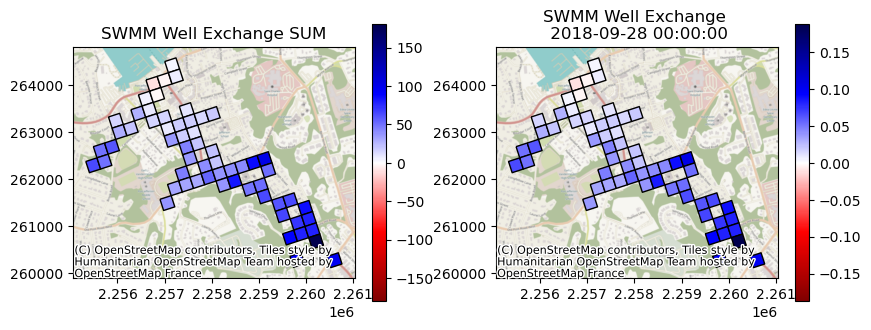

In [29]:
date = pd.Timestamp('2018-09-28 00:00:00')
sim = sim_dirs[3]
sum_values= []
values =[]

# POPULATE GEODATAFRAMES WITH WELL EXCHANGE VALUES
# ---------------------------------------------------
mg_well = mg_gdf.copy()
mg_well['well_flux'] =float(0)

mg_well1 = mg_gdf.copy()
mg_well1['well_flux'] =float(0)

for name,l,r,c in zip(obscells_wells['obs_name'],obscells_wells['lay'],obscells_wells['row'], obscells_wells['col']):
    if name in cols_with_value:
        continue
    else:
        # SUM OF WELL EXCHANGE
        sum_value = obsdict_WELstats[sim][name]['sum']
        sum_values.append(sum_value)
        # populate mode grid with well values 
        mg_well.loc[((mg_well['row_pj'] == r) & (mg_well['col_pj'] == c)),'well_flux'] = sum_value
        # WELL EXCHANGE AT TIMESTEP
        value = obsdict_WEL[sim][name][date]
        values.append(value)
        # populate mode grid with well values 
        mg_well1.loc[((mg_well1['row_pj'] == r) & (mg_well1['col_pj'] == c)),'well_flux'] = value

fig,ax = plt.subplots(1,2, figsize = (10,6))
# PLOT SUM OF WELL EXCHANGE
vmax = max(sum_values)
vmin = min(sum_values)
absmax = max(abs(vmax),abs(vmin))
mg_well.loc[mg_well['well_flux']!=0].plot(column = 'well_flux',ax=ax[0], vmin = -absmax, vmax = absmax,cmap = 'seismic_r' ,legend = True, edgecolor = 'k', legend_kwds={"shrink": 0.6} )
cx.add_basemap(ax=ax[0], crs = mg_well.crs)
ax[0].set_title(f'SWMM Well Exchange SUM')

# PLOT WELL EXCHANGE AT TIMESTEP
vmax = max(values)
vmin = min(values)
absmax = max(abs(vmax),abs(vmin))
mg_well1.loc[mg_well1['well_flux']!=0].plot(column = 'well_flux',ax=ax[1], vmin = -absmax, vmax = absmax,cmap = 'seismic_r' ,legend = True, edgecolor = 'k', legend_kwds={"shrink": 0.6} )
cx.add_basemap(ax=ax[1], crs = mg_well1.crs)
ax[1].set_title(f'SWMM Well Exchange \n {date}')
fig.savefig('figures/WellExchaneMap.jpeg')

0 run_04.00H_withSWMM
1 run_02.00H_withSWMM
2 run_01.00H_withSWMM
3 run_15.00M_withSWMM
4 run_15.00M_withSWMM1min


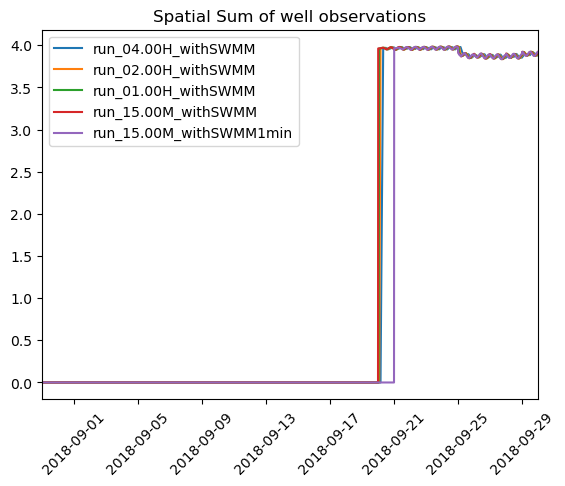

In [30]:

start_date = pd.to_datetime('2018-08-30')
end_date = pd.to_datetime('2018-09-30')

fig,ax = plt.subplots()
for i,sim in enumerate(sim_dirs):
    ax.plot(obsdict_WEL[sim]['TOTAL'], label = sim)
    print(i,sim)
ax.set_title('Spatial Sum of well observations')
ax.legend()
ax.set_xlim(start_date,end_date)
ax.tick_params(axis="x", rotation=45)

## daily vs. minute

0 run_15.00M_withSWMM
1 run_15.00M_withSWMM1min


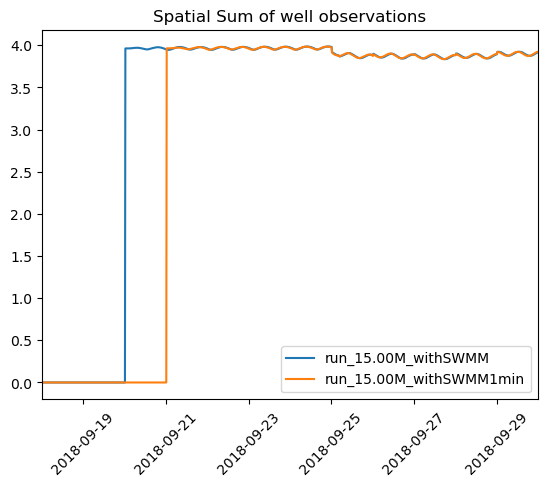

In [31]:

start_date = pd.to_datetime('2018-09-18')
end_date = pd.to_datetime('2018-09-30')

fig,ax = plt.subplots()
for i,sim in enumerate(['run_15.00M_withSWMM','run_15.00M_withSWMM1min']):
    ax.plot(obsdict_WEL[sim]['TOTAL'], label = sim)
    print(i,sim)
ax.set_title('Spatial Sum of well observations')
ax.legend()
ax.set_xlim(start_date,end_date)
ax.tick_params(axis="x", rotation=45)

# Head Observations

In [32]:
# GWF Obs Cells
# #=====================================================
obscells_heads = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])
# Replace *any* whitespace in cellid with commas
obscells_heads['cellid'] = obscells_heads['cellid'].str.replace(r'\s+', ',', regex=True)
# Split into new columns
obscells_heads[['lay', 'row', 'col']] = obscells_heads['cellid'].str.split(',', expand=True)
obscells_heads = obscells_heads.iloc[:-1]
obscells_heads[['lay', 'row', 'col']] = obscells_heads[['lay', 'row', 'col']].astype(int)
obscells_heads[['lay', 'row', 'col']]-=1

# GWF Obs 
#=========
obsdict_head = {}
for sim in sim_dirs+sim_dirs_noswmm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\hd_obs.csv'
    print(obs_path)
    #df = flopy.utils.Mf6Obs(obs_path).get_dataframe()  
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    obsdict_head[sim] = df

..\modflow\pj_2018_adjust_CHDA1\run_04.00H_withSWMM\outputs\hd_obs.csv


C:\Users\bbayrakt\AppData\Local\Temp\1\ipykernel_30224\1626000611.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  obscells_heads = pd.read_csv(fr"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\modflow\pj_2018_adjust_CHDA1\base\gwf.obs",skiprows=5, sep=r'  ', names = ['obs_name','head','cellid'])


..\modflow\pj_2018_adjust_CHDA1\run_02.00H_withSWMM\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_01.00H_withSWMM\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M_withSWMM1min\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_04.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_02.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_01.00H\outputs\hd_obs.csv
..\modflow\pj_2018_adjust_CHDA1\run_15.00M\outputs\hd_obs.csv


## Heads @ SWMM junctions

0 67 63
0 68 61
0 73 61
0 71 63
0 69 61


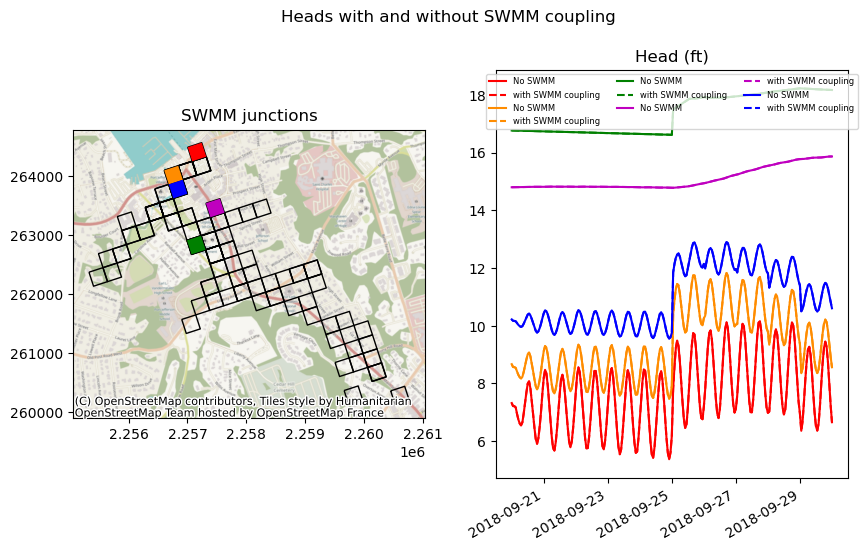

In [33]:
sim = 'run_01.00H'
sim_swmm = 'run_01.00H_withSWMM'
colors = ['r', 'darkorange', 'g', 'm', 'b', 'k']
start_date = pd.to_datetime('2018-09-20')
end_date = pd.to_datetime('2018-09-30')

fig,ax=plt.subplots(1,2, figsize = (10,6))
for r,c in zip(obscells_wells['row'], obscells_wells['col']):
    mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0], facecolor = 'none', edgecolor = 'k')

for i,name in enumerate(['J97','J98', 'J50', 'J58','J86']):
    # determine the l,r,c of the swmm wells
    l,r,c = obscells_wells.loc[obscells_wells['obs_name'] == name, ['lay','row','col']].iloc[0]
    print(l,r,c)
    # get head observation name from lrc
    obs_name = obscells_heads.loc[
        (obscells_heads['lay'] == l) &
        (obscells_heads['row'] == r) &
        (obscells_heads['col'] == c), 
        'obs_name'
    ].iloc[0]
    # observation data
    df  = obsdict_head[sim][obs_name.upper()][start_date:end_date]
    # PLOT
    #=============
    mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0], color = colors[i])
    ax[0].set_title('SWMM junctions')
    # without swmm coupling 
    df.plot(
        x="Time",
        ax=ax[1],
        color=colors[i],legend=True, label = f'No SWMM'
    )
    # with swmm coupling
    df  = obsdict_head[sim_swmm][obs_name.upper()][start_date:end_date]
    df.plot(
        x="Time",
linestyle='--',
        ax=ax[1],
        color=colors[i],legend=True, label = f'with SWMM coupling'
    )
    ax[1].set_title('Head (ft)')
#ax[0].margins(0.8)
cx.add_basemap(ax=ax[0], crs=mg_gdf.crs)
ax[1].legend(ncol=3, loc="upper center", fontsize = 6)
fig.suptitle('Heads with and without SWMM coupling')
fig.savefig('figures/heads_with_SWMM.jpeg')

## Observed vs. Simulated in PJ

In [34]:
pj_network = gpd.read_file("../../../GIS/PJ_mininetwork_2024/PJ_mininetwork_withsensors.shp")
pj_network.to_crs(epsg=4456,inplace=True)
print(pj_network.crs)
# 'screen_top' is the depth to the screen from the casing 
# 'casing_top' is in reference to ft above msl
# calculate 'screen_top_msl' which is in reference to sea-level, by su
pj_network['screen_top_msl'] = pj_network['casing_top']- pj_network['screen_top']
# Determine where the wells intersect the model grid
pj_network_modelcells = gpd.sjoin(mg_gdf,pj_network,how = 'inner', predicate='intersects')

# # MAP OF PJ MONITORING SITES
# # =========================
# fig, ax = plt.subplots(figsize=(5, 5))
# for r,c in zip(obscells_wells['row'], obscells_wells['col']):
#     mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0], color = 'r')
# # Plot the points with legend
# pj_network_modelcells.plot(ax=ax)
# pj_network.plot(column='Site',  ax=ax)
# cx.add_basemap(ax, crs=pj_network.crs)
# for idx, row in pj_network.iterrows():
#     x, y = row.geometry.x, row.geometry.y
#     label = row['Site']  # Change to another column if preferred
#     ax.text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
# plt.show()


# IMPORT AND SAVE PJ WATER LEVEL OBSERVATIONS
# =================================================
from pathlib import Path

lai_dict = {}

# GROUNDWATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/gw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    f['Date/Time'] = pd.to_datetime(f['Date/Time'])
    lai_dict[file.name[:-4]] = f
# SURFACE WATER
path = Path('../../../PJ_2024WaterLevelNetwork/data/sw')
for file in path.glob('*.csv'):
    f =pd.read_csv(file)
    lai_dict[file.name[:-4]] = f
    f['Time'] = pd.to_datetime(f['Time'])


EPSG:4456


Marina OBS_110_L0 0 66 60
ERT-MW-1A: screen top elevation =-35.67, layer=6, layer_val=-26.9
ERT-MW-1B: screen top elevation =-60.62, layer=7, layer_val=-82.23
MillCreek OBS_158_L0 0 69 60
ERT-MW-4B: screen top elevation =-112.21, layer=7, layer_val=-97.2
MW-PD-17: screen top elevation =-55.260000000000005, layer=6, layer_val=-49.37


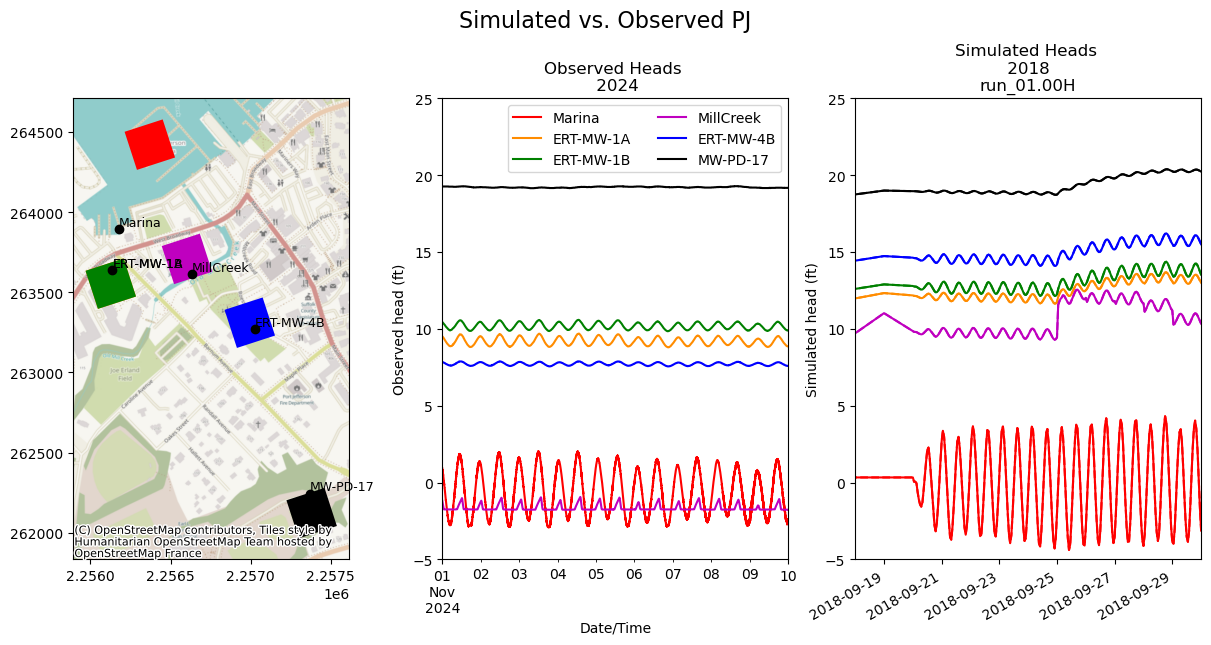

In [35]:
sim = 'run_01.00H'
sim_swmm = 'run_01.00H_withSWMM'
colors = ['r', 'darkorange', 'g', 'm', 'b', 'k']
start_date = pd.Timestamp('2018-09-18 00:00:00')
fig, ax = plt.subplots(1, 3, figsize=(12, 6), constrained_layout=True)
# Plot site map
#==================
# pj_network_modelcells.plot(ax=ax[0])
# pj_network.plot(column='Site',  ax=ax[0])
# cx.add_basemap(ax=ax[0], crs=pj_network.crs)


for idx, (wellname, screentop, r, c) in enumerate(zip(
        pj_network_modelcells['Site'],
        pj_network_modelcells['screen_top_msl'],
        pj_network_modelcells['row_pj'],
        pj_network_modelcells['col_pj'])):

    if not np.isnan(screentop):
        stack = lay_arr[:, r, c]
        l = (np.abs(stack - screentop)).argmin()
        print(f"{wellname}: screen top elevation ={screentop}, layer={l}, layer_val={stack[l]}")

        obs_name = obscells_heads.loc[
            (obscells_heads['lay'] == l) &
            (obscells_heads['row'] == r) &
            (obscells_heads['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")


        # Map 
        #pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
        mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0],color = colors[idx])
        pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color ='k')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Date/Time', y='WLE estimate', label=wellname, color = colors [idx])
        # Simulated
        obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])
        obsdict_head[sim_swmm][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', linestyle = '--', color = colors [idx])

    else:
        if wellname == 'Marina':
            l, r, c = 0, 66, 60
           # l, r, c = 0, r,c
        if wellname == 'MillCreek':
            l, r, c = 0, r, c
        obs_name = obscells_heads.loc[
            (obscells_heads['lay'] == l) &
            (obscells_heads['row'] == r) &
            (obscells_heads['col'] == c), 'obs_name'
        ].iloc[0].upper().replace("'", "")

        print(wellname,obs_name, l,r,c)
        # Map 
        # pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
        mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax=ax[0],color = colors[idx])
        pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color = 'k')
        # Observed
        lai_dict[wellname].plot(ax=ax[1], x='Time', y='elevation', label=wellname, color = colors [idx])
        # Simulated
        obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])
        obsdict_head[sim_swmm][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', linestyle = '--',color = colors [idx])


for idx, row in pj_network.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row['Site']  # Change to another column if preferred
    ax[0].text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
cx.add_basemap(ax=ax[0], crs=pj_network.crs)

# Styling observed plot
ax[1].legend(ncol = 2)
ax[1].set_xlim('2024-11-1', '2024-11-10')
ax[1].set_ylabel('Observed head (ft)')
ax[1].set_title('Observed Heads \n 2024')
ax[1].set_ylim(-5, 25)


# Styling simulated plot
#ax[2].legend(ncol=1, loc = 'upper left')
ax[2].set_xlim(start_date, df.index[-1])
ax[2].set_ylabel('Simulated head (ft)')
ax[2].set_title(f'Simulated Heads \n 2018 \n{sim}')
ax[2].set_ylim(-5, 25)


# Common title
fig.suptitle('Simulated vs. Observed PJ', fontsize=16, y=1.05)

plt.show()


In [36]:
# sim = 'run_01.00H'
# sim_swmm = 'run_01.00H_withSWMM'
# colors = ['r', 'darkorange', 'g', 'm', 'b', 'k']
# start_date = pd.Timestamp('2018-09-18 00:00:00')
# fig, ax = plt.subplots(1, 3, figsize=(12, 6), constrained_layout=True)
# # mg_gdf.plot(ax=ax,facecolor='none', edgecolor='black',linewidth=0.1)
# for r,c in zip(obscells_wells['row'], obscells_wells['col']):
#     mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0], facecolor = 'none',edgecolor = 'r',linewidth=0.1)

# for idx, (wellname, screentop, r, c) in enumerate(zip(
#         pj_network_modelcells['Site'],
#         pj_network_modelcells['screen_top_msl'],
#         pj_network_modelcells['row_pj'],
#         pj_network_modelcells['col_pj'])):

#     if not np.isnan(screentop):
#         stack = lay_arr[:, r, c]
#         l = (np.abs(stack - screentop)).argmin()
#         print(f"{wellname}: screen top elevation ={screentop}, layer={l}, layer_val={stack[l]}")

#         obs_name = obscells_heads.loc[
#             (obscells_heads['lay'] == l) &
#             (obscells_heads['row'] == r) &
#             (obscells_heads['col'] == c), 'obs_name'
#         ].iloc[0].upper().replace("'", "")


#         # Map 
#         #pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
#         mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax = ax[0],color = colors[idx])
#         pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color ='k')
#         # Observed
#         lai_dict[wellname].plot(ax=ax[1], x='Date/Time', y='WLE estimate', label=wellname, color = colors [idx])
#         # Simulated
#         obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])
#         obsdict_head[sim_swmm][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', linestyle = '--', color = colors [idx])

#     else:
#         if wellname == 'Marina':
#             l, r, c = 0, 66, 60
#            # l, r, c = 0, r,c
#         if wellname == 'MillCreek':
#             l, r, c = 0, r, c
#         obs_name = obscells_heads.loc[
#             (obscells_heads['lay'] == l) &
#             (obscells_heads['row'] == r) &
#             (obscells_heads['col'] == c), 'obs_name'
#         ].iloc[0].upper().replace("'", "")

#         print(wellname,obs_name, l,r,c)
#         # Map 
#         # pj_network_modelcells.loc[pj_network_modelcells['Site'] == wellname].plot(ax=ax[0], color = colors [idx])
#         mg_gdf[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(ax=ax[0],color = colors[idx])
#         pj_network.loc[pj_network['Site'] == wellname].plot(ax=ax[0], color = 'k')
#         # Observed
#         lai_dict[wellname].plot(ax=ax[1], x='Time', y='elevation', label=wellname, color = colors [idx])
#         # Simulated
#         obsdict_head[sim][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', color = colors [idx])
#         obsdict_head[sim_swmm][obs_name].plot(x="Time", ax=ax[2], label=f'{wellname}:{l,r,c}', linestyle = '--',color = colors [idx])


# for idx, row in pj_network.iterrows():
#     x, y = row.geometry.x, row.geometry.y
#     label = row['Site']  # Change to another column if preferred
#     ax[0].text(x, y, label, fontsize=9, ha='left', va='bottom', color='black')
# cx.add_basemap(ax=ax[0], crs=pj_network.crs)

# # Styling observed plot
# ax[1].legend(ncol = 2)
# ax[1].set_xlim('2024-11-1', '2024-11-10')
# ax[1].set_ylabel('Observed head (ft)')
# ax[1].set_title('Observed Heads')
# ax[1].set_ylim(-5, 25)


# # Styling simulated plot
# #ax[2].legend(ncol=1, loc = 'upper left')
# ax[2].set_xlim(start_date, df.index[-1])
# ax[2].set_ylabel('Simulated head (ft)')
# ax[2].set_title(f'Simulated Heads \n {sim}')
# ax[2].set_ylim(-5, 25)


# # Common title
# fig.suptitle('Simulated vs. Observed PJ', fontsize=16, y=1.05)

# plt.show()


## Coastal Heads

Text(0.5, 0.98, '(16, 39)\nrun_01.00H')

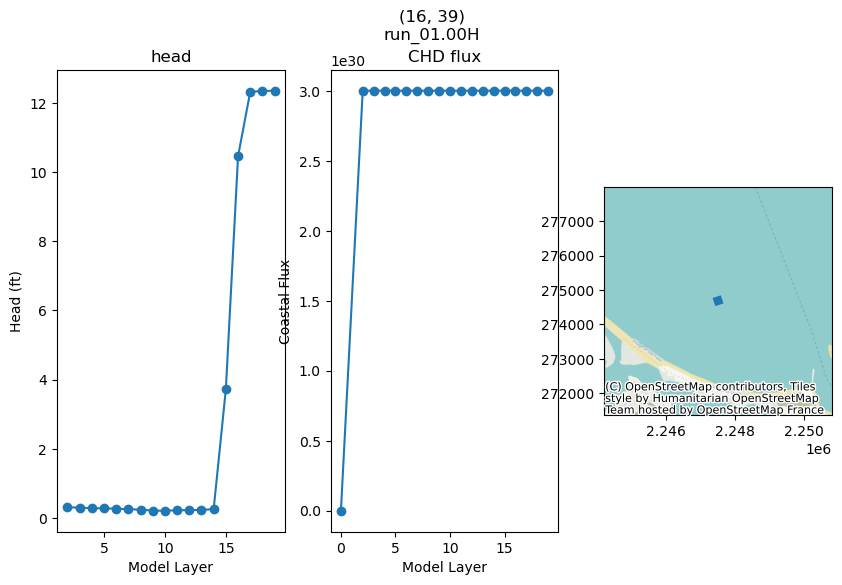

In [37]:
x = []
y = []
x1 = []
y1 = []
sim ='run_01.00H'
datetimes  = "2018-09-29 00:00:00.000000" ,  "2018-09-29 06:00:00.000000"

r = 16
c = 39

fig,ax= plt.subplots(1,3, figsize = (10,6))
name_chd = obscells_CHD.loc[((obscells_CHD['lay'] == 0) & 
                                    (obscells_CHD['row']== r) & 
                                    (obscells_CHD['col'] == c)), 'chd_name'].iloc[0].upper().replace("'", "")
value_chd = obsdict_CHDsurface[sim]["df"][name_chd].loc[datetimes[0]]
#print(value_chd)
x1.append(0)
y1.append(value_chd)

for i in range(2,20):
    l = i
    name = obscells_heads.loc[
        (obscells_heads['lay'] == l) & 
        (obscells_heads['row'] == r) & 
        (obscells_heads['col'] == c),
        'obs_name'
    ].iloc[0].upper().replace("'", "")
    value = obsdict_head[sim][name].loc[datetimes[0]]
    #print(l,r,c,value)
    x.append(i)
    y.append(value)

    name_chd = obscells_CHD.loc[((obscells_CHD['lay'] == l) & 
                                      (obscells_CHD['row']== r) & 
                                      (obscells_CHD['col'] == c)), 'chd_name'].iloc[0].upper().replace("'", "")
    value_chd = obsdict_CHDdepth[sim]["df"][name_chd].loc[datetimes[0]]
    x1.append(i)
    y1.append(value_chd)



ax[0].plot(x, y, marker="o")  
ax[0].set_xlabel('Model Layer')
ax[0].set_ylabel('Head (ft)')
ax[0].set_title('head')
ax[1].plot(x1, y1, marker="o")
ax[1].set_xlabel('Model Layer')
#ax[1].set_yscale('log')
ax[1].set_ylabel('Coastal Flux')
ax[1].set_title('CHD flux')

mg_chd.loc[((mg_chd['row_pj'] == r) & (mg_chd['col_pj'] == c))].plot(ax=ax[2])
ax[2].margins(10)
cx.add_basemap(ax=ax[2], crs = mg_gdf.crs)

fig.suptitle(f'{r,c}\n{sim}')



c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

                         geometry
0  POINT (662172.503 4535164.398) 0 60 60
                         geometry
0  POINT (662342.196 4534900.004) 0 64 61
                         geometry
0  POINT (662270.938 4534634.676) 0 67 59
                         geometry
0  POINT (662343.130 4534659.051) 0 67 60


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

'0 60 60'
0 60 60


TypeError: No numeric data to plot.

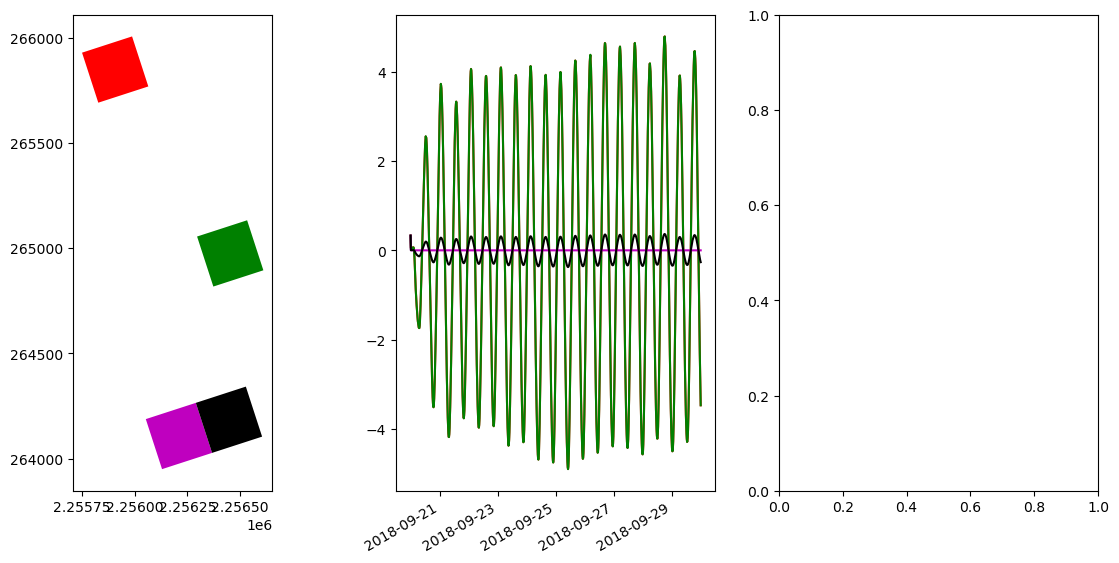

In [38]:
import re
#=================================================================
coords_UTM = []
start_date = pd.to_datetime('2018-09-20')
end_date = pd.to_datetime('2018-09-30')
colors = ['r','g','m','k']

sim = sim_dirs[3]
# CHD head Time Series 
fig, ax = plt.subplots(1, 3, figsize=(14, 7))

for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):
    # assert the cells are CHDs
    assert ((obscells_CHD["lay"] == l) & (obscells_CHD["row"] == r) & (obscells_CHD["col"] == c)).any()

    # get the coordinated of the center of these cells (in UTM) to be used in the DFLOW-FM observation file to ensure that the heads are the same when coupling
    # ----------------------------------------------
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    point.to_crs(epsg=32618, inplace=True)
    print(point, l,r,c)
    coords_UTM.append(point)


    # plot the map locations
    #-------------------------
    mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)].plot(
        ax=ax[0], color=colors[i]
    )

    # Plot the Modflow Head Observations
    #----------------------------------
    # get observation name
    obs_name = obscells_heads.loc[
        (obscells_heads['lay'] == 0) &
        (obscells_heads['row'] == r) &
        (obscells_heads['col'] == c), 
        'obs_name'
    ].iloc[0]
    obs_name = obs_name.upper()
    plot_df  = obsdict_head[sim][obs_name][start_date:end_date]
    # save out for liv
    #plot_df.to_csv(f'tides/tide_{l,r,c}.txt')
    # plot time series
    plot_df.plot(
        x="Time",
        label=f'{l, r, c}',
        ax=ax[1],
        color=colors[i]
    )

# Plot the Dflow water level observations
# ------------------------------------------
ds = xugrid.open_dataset(r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_his.nc")
# ds = ds.set_xindex("station_name")
station_dict = dict(zip(ds.stations.data, ds.stations['station_name'].data))
# loop through the observations that line up with the mf cell observations
for i,x in enumerate(range(23,27)): 
    station_name = station_dict[x]

    # If it's a byte string, decode to str
    if isinstance(station_name, (bytes, bytearray)):
        station_name = station_name.decode("utf-8", errors="ignore")

    # Strip trailing/leading whitespace
    station_name = station_name.strip()

    print(repr(station_name))  # should now look like '0,60,60'
    print(station_name)
    # convert data to feet
    data = ds.isel(stations=x)['waterlevel'] * 3.28 
    data.plot(ax=ax[2], label = station_name, color = colors[i])
    


# expand map extent by 10% (simple way)
ax[0].margins(0.8)
cx.add_basemap(ax=ax[0], crs=mg_gdf.crs)

# format time series panel
#ax[1].legend(ncol=2,bbox_to_anchor=(0.2, 1),)
ax[1].legend(ncol=2)
ax[1].set_title('Modflow water levels(ft)')

ax[2].set_title('DFlow-FM water levels (ft)')
ax[2].legend(ncol=2)

fig.suptitle(f'Water Levels \n {sim}')
# add basemap


                         geometry
0  POINT (662172.503 4535164.398) 0 60 60
                         geometry
0  POINT (662342.196 4534900.004) 0 64 61
                         geometry
0  POINT (662270.938 4534634.676) 0 67 59
                         geometry
0  POINT (662343.130 4534659.051) 0 67 60
'0 60 60'
0 60 60
'0 64 61'
0 64 61
'0 67 59'
0 67 59
'0 67 60'
0 67 60


c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\bbayrakt\AppData\Local\miniforge3\envs\liss\lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

Text(0.5, 0.98, 'Water Levels \n run_15.00M_withSWMM')

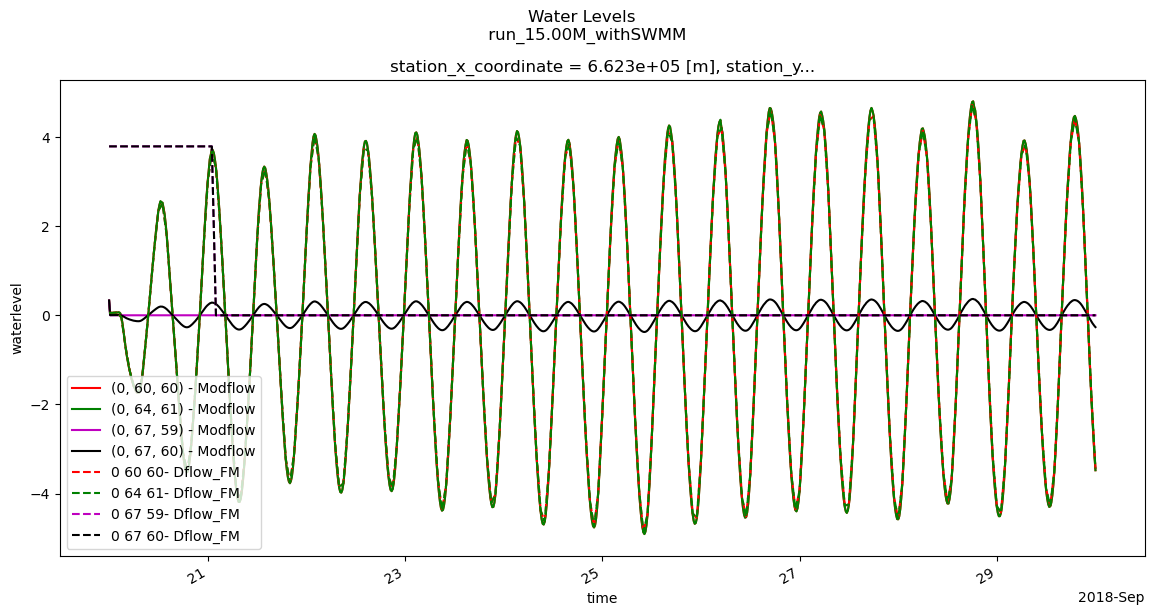

In [ ]:
import re
#=================================================================
coords_UTM = []
start_date = pd.to_datetime('2018-09-20')
end_date = pd.to_datetime('2018-09-30')
sim = sim_dirs[3]
colors = ['r','g','m','k']
# CHD head Time Series 
fig, ax = plt.subplots(1, figsize=(14, 7))

for i, (l, r, c) in enumerate([(0, 60, 60), (0, 64, 61), (0, 67, 59), (0, 67, 60)]):
    # assert the cells are CHDs
    assert ((obscells_CHD["lay"] == l) & (obscells_CHD["row"] == r) & (obscells_CHD["col"] == c)).any()

    # get the coordinated of the center of these cells (in UTM) to be used in the DFLOW-FM observation file to ensure that the heads are the same when coupling
    # ----------------------------------------------
    xs = [mg.xcellcenters[r,c]]
    xy = [mg.ycellcenters[r,c]]
    point = gpd.GeoDataFrame(geometry=gpd.points_from_xy(xs, xy), crs="EPSG:4456")
    point.to_crs(epsg=32618, inplace=True)
    print(point, l,r,c)
    coords_UTM.append(point)

    # Plot the Modflow Head Observations
    #----------------------------------
    # get observation name
    obs_name = obscells_heads.loc[
        (obscells_heads['lay'] == 0) &
        (obscells_heads['row'] == r) &
        (obscells_heads['col'] == c), 
        'obs_name'
    ].iloc[0]
    obs_name = obs_name.upper()
    plot_df  = obsdict_head[sim][obs_name][start_date:end_date]
    # save out for liv
    #plot_df.to_csv(f'tides/tide_{l,r,c}.txt')
    # plot time series
    plot_df.plot(
        x="Time",
        label=f'{l, r, c} - Modflow',
        ax=ax,
        color=colors[i]
    )
ax.legend()

# Plot the Dflow water level observations
# ------------------------------------------
ds = xugrid.open_dataset(r"D:\LISS_GW\GitRepo_CoupledModels\nywsc_compound_flooding\dflow-fm\coarse\tides_2018_atm\run\output\FlowFM_his.nc")
# ds = ds.set_xindex("station_name")
station_dict = dict(zip(ds.stations.data, ds.stations['station_name'].data))
# loop through the observations that line up with the mf cell observations
for i,x in enumerate(range(23,27)): 
    station_name = station_dict[x]

    # If it's a byte string, decode to str
    if isinstance(station_name, (bytes, bytearray)):
        station_name = station_name.decode("utf-8", errors="ignore")

    # Strip trailing/leading whitespace
    station_name = station_name.strip()

    print(repr(station_name))  # should now look like '0,60,60'
    print(station_name)
    # convert data to feet
    data = ds.isel(stations=x)['waterlevel'] * 3.28 
    data.plot(ax=ax, label = f'{station_name}- Dflow_FM', color = colors[i], linestyle = '--')
ax.legend()
fig.suptitle(f'Water Levels \n {sim}')
# add basemap


## Head Contours


### Coupling with and without SWMM

## Time Series

coastal heads : dflow versions

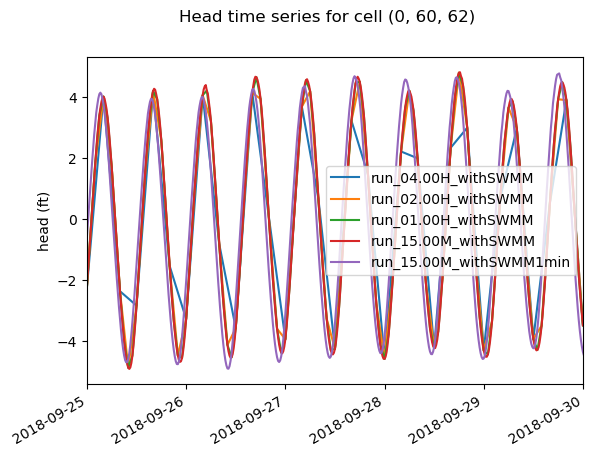

In [ ]:
sim_dict_headobs = {}

l,r,c = 0,60,62
obs_name = obscells_heads.loc[((obscells_heads['lay'] == l) & (obscells_heads['row'] == r) & (obscells_heads['col'] == c)), 'obs_name'].iloc[0]
obs_name =obs_name.upper()
obs_name

start_date = pd.Timestamp('2018-09-25 00:00:00')

fig,ax = plt.subplots()
for sim in sim_dirs:
    #Plot Figure
    obsdict_head[sim][obs_name].plot(x = "Time",ax=ax, label = f'{sim}')
ax.legend()
ax.set_xlim(start_date, df.index[-1])
plt.ylabel('head (ft)')
fig.suptitle(f'Head time series for cell {l,r,c}')
plt.show()

# geodataframe of cells to check
cell_location = pd.concat(
    [mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)]])
cell_location.explore(color ="MAGENTA")

..\modflow\pj_2018_adjust_CHDA1\run_NoAtm_01.00H\outputs\hd_obs.csv


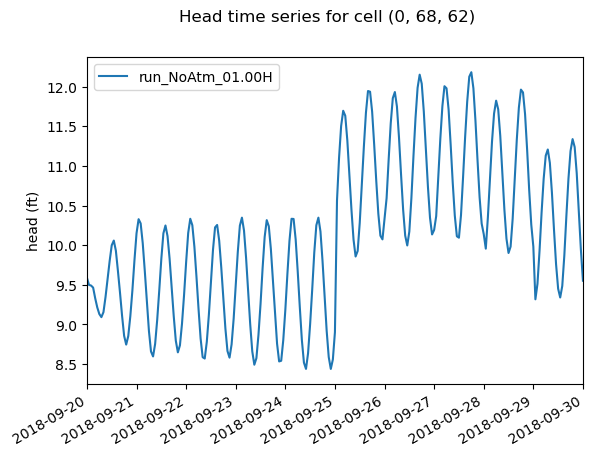

In [ ]:
sim_dict_headobs = {}

l,r,c = 0,68,62
obs_name = obscells_heads.loc[((obscells_heads['lay'] == l) & (obscells_heads['row'] == r) & (obscells_heads['col'] == c)), 'obs_name'].iloc[0]
obs_name =obs_name.upper()
obs_name

start_date = pd.Timestamp('2018-09-20 00:00:00')

fig,ax = plt.subplots()
for sim in sim_dirs_noatm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\hd_obs.csv'
    print(obs_path)
    #df = flopy.utils.Mf6Obs(obs_path).get_dataframe()  
    # Load the GHB observations
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    sim_dict_headobs[sim] = df

    #Plot Figure
    df[obs_name].plot(x = "Time",ax=ax, label = f'{sim}')
ax.legend()
ax.set_xlim(start_date, df.index[-1])
plt.ylabel('head (ft)')
fig.suptitle(f'Head time series for cell {l,r,c}')
plt.show()

# geodataframe of cells to check
cell_location = pd.concat(
    [mg_gdf.loc[(mg_gdf['row_pj'] == r) & (mg_gdf['col_pj'] == c)]])
cell_location.explore(color ="MAGENTA")

# Drain Observations 

In [136]:
df.abs()

UFuncTypeError: ufunc 'absolute' did not contain a loop with signature matching types <class 'numpy.dtypes.DateTime64DType'> -> None

In [140]:
# GWF Obs 
#=========
obsdict_drn = {}
obsdict_drnABS = {}
for sim in sim_dirs+sim_dirs_noswmm:
    obs_path  = fr'..\modflow\pj_2018_adjust_CHDA1\{sim}\outputs\drn_obs.csv'
    df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
    df_abs = df.abs()

    df = df.merge(mf_tdis_df[['totim','Date']], how= 'left')
    df_abs = df_abs.merge(mf_tdis_df[['totim','Date']], how= 'left')
    
    obsdict_drn[sim] = df
    obsdict_drnABS[sim] = df_abs
# uncoupled drain observations
obs_path = r"D:\LISS_GW\GW_Models\LISUS_conditionedmodels_BNB\2018\conditioned_model_2018_daily\_mfsetup\models\pj_2018_adjust_CHDA1\outputs\drn_obs.csv"
df = flopy.utils.Mf6Obs(obs_path).get_dataframe(start_datetime="1-1-2017")
df_abs = df.abs()
df = df.merge(mf_tdis_df[['totim','Date']], how= 'left')
df_abs = df_abs.merge(mf_tdis_df[['totim','Date']], how= 'left')
obsdict_drn['uncoupled'] = df
obsdict_drnABS['uncoupled'] = df_abs



627.0 637.0


Text(0.5, 1.0, 'Mill Creek Observations (absolute value)')

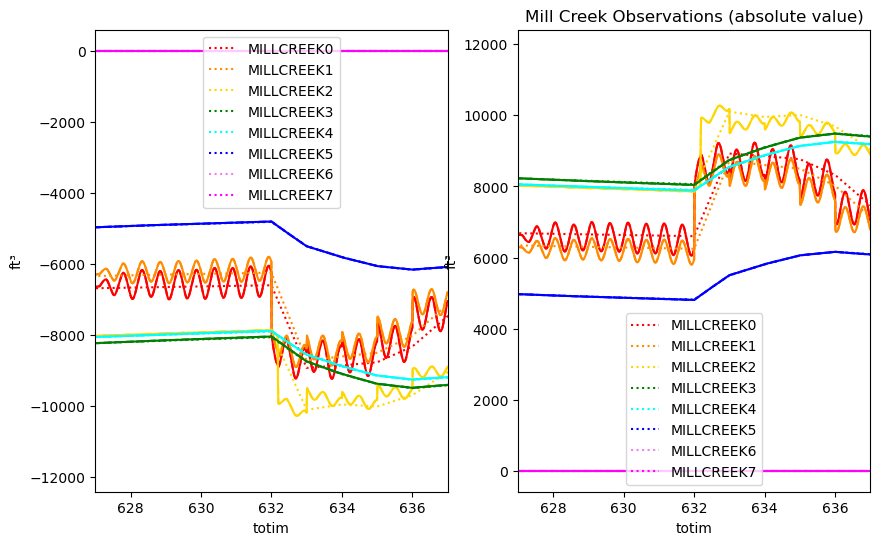

In [143]:
date_ll = '2018-09-19'
date_ul = '2018-09-29'
totim_ll = mf_tdis_df.loc[mf_tdis_df['Date']== date_ll, 'totim'].iloc[0]
totim_ul = mf_tdis_df.loc[mf_tdis_df['Date']== date_ul, 'totim'].iloc[0]
print(totim_ll, totim_ul)


colors = ['red', 'darkorange', 'gold', 'green', 'cyan', 'blue', 'violet', 'magenta']
fig, axes = plt.subplots(1,2, figsize = (10,6)) 
for i in range(0, 8):
    obsdict_drn['run_15.00M'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[0], color = colors[i], legend= False)
    obsdict_drnABS['run_15.00M'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[1], color = colors[i], legend= False)    

    obsdict_drn['run_15.00M_withSWMM'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[0], linestyle = '--', color = colors[i], legend= False)
    obsdict_drnABS['run_15.00M_withSWMM'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[1], linestyle = '--', color = colors[i], legend= False)

    obsdict_drn['uncoupled'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[0], linestyle = ':', color = colors[i], legend= True)
    obsdict_drnABS['uncoupled'].plot(x='totim', y=f'MILLCREEK{i}', ax=axes[1], linestyle = ':', color = colors[i], legend= True)

for ax in axes:
    ax.set_xlim(totim_ll,totim_ul)
    ax.set_ylabel('ft³')

axes[1].set_title('Mill Creek Observations (absolute value)')